# Intro to AI | Clustering & Classification (County Health Rankings 2025)

This notebook is for my Intro to AI class at CMU, Fall 2025. It uses clustering, EDA, and supervised learning on the country health rankings dataset from 2025.

- Data source: County Health Rankings 2025 Analytic CSV (`analytic_data2025_v2.csv`). See CHR docs in `docs_texts/`.
- Documentation: “2025 CHR CSV/SAS Analytic Data Documentation” and “2025 Data Dictionary (PDF)”.
- Academic Integrity: Work is my own; external libraries cited in `requirements.txt`.

## Sections
1. Setup
2. Data
3. Feature Selection
4. EDA
5. Preprocessing
6. Clustering
7. Supervised Learning: Predicting Death
8. Recommendations for Allegheny County

## 1. Setup

In [230]:
# Restrict features to Select Measures (This took a while)
import re
import pandas as pd

# Load data here
try:
    df  # type: ignore[name-defined]
except NameError:
    df = pd.read_csv('analytic_data2025_v2.csv')

# Create a list of the Selected measures
SELECT_MEASURE_IDS = {
    '132',  # Access to Exercise Opportunities
    '155',  # Flu Vaccinations
    '133',  # Food Environment Index
    '005',  # Preventable Hospital Stays
    '085',  # Uninsured
    '004',  # Primary Care Physicians
    '050',  # Mammography Screening
    '062',  # Mental Health Providers
    '088',  # Dentists
    '125',  # Air Pollution: PM2.5
    '124',  # Drinking Water Violations
    '166',  # Broadband Access
    '181',  # Library Access
    '136',  # Severe Housing Problems
    '067',  # Driving Alone to Work
    '137',  # Long Commute - Driving Alone
    '168',  # High School Completion
    '069',  # Some College
    '023',  # Unemployment
    '024',  # Children in Poverty
    '044',  # Income Inequality
    '171',  # Child Care Cost Burden
    '135',  # Injury Deaths
    '140',  # Social Associations
}

# Regex to keep select measures
_select_ids_pattern = re.compile(r'^v(' + '|'.join(sorted(SELECT_MEASURE_IDS)) + r')_rawvalue$')

feature_cols_select = [c for c in df.columns if _select_ids_pattern.match(c)]

# Make sure premature death is not in the feature set
assert 'v001_rawvalue' not in feature_cols_select, 'Premature Death (v001_rawvalue) should not be in features.'

# Final feature matrix used throughout the notebook
X_select = df[feature_cols_select].copy()
X = X_select  # for compatibility if later cells expect X

# Keeping the id columns if I want to use them later
_id_cols = [c for c in ['statecode', 'countycode', 'fipscode', 'state', 'county', 'year'] if c in df.columns]
df_ids_features = pd.concat([df[_id_cols], X_select], axis=1) if _id_cols else X_select

# Print the features
print(f'Using {len(feature_cols_select)} Select Measures features:')
print(sorted(feature_cols_select))

# Make sure premature death is in the dataframe
y_col = 'v001_rawvalue'  # Premature Death raw value (target)
if y_col not in df.columns:
    raise KeyError(f'Missing target column {y_col} in dataframe.')

y = df[y_col].copy()
print('Target set to Premature Death (v001_rawvalue).')

Using 24 Select Measures features:
['v004_rawvalue', 'v005_rawvalue', 'v023_rawvalue', 'v024_rawvalue', 'v044_rawvalue', 'v050_rawvalue', 'v062_rawvalue', 'v067_rawvalue', 'v069_rawvalue', 'v085_rawvalue', 'v088_rawvalue', 'v124_rawvalue', 'v125_rawvalue', 'v132_rawvalue', 'v133_rawvalue', 'v135_rawvalue', 'v136_rawvalue', 'v137_rawvalue', 'v140_rawvalue', 'v155_rawvalue', 'v166_rawvalue', 'v168_rawvalue', 'v171_rawvalue', 'v181_rawvalue']
Target set to Premature Death (v001_rawvalue).


In [231]:
# General Setup
import os
import sys
import warnings
import numpy as np
from pathlib import Path

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn imports as needed
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

RANDOM_STATE = 42 # Random seed for reproducibility, based on the answer to life's biggest question
np.random.seed(RANDOM_STATE)

# Data pathing and check for the data file
DATA_PATH = Path('analytic_data2025_v2.csv')
assert DATA_PATH.exists(), f"Data file not found at {DATA_PATH.resolve()}"

## 2. Data

In [232]:
# Read raw CSV
_df0 = pd.read_csv(DATA_PATH)
print('Dataframe shape:', _df0.shape)

display(_df0.head(3)) # Display the first 3 rows of the dataframe

# Remap headers if the first data row contains the coded names (e.g., 'v001_rawvalue')
expected_target = 'v001_rawvalue'
if expected_target not in _df0.columns and expected_target in set(_df0.iloc[0].astype(str).values):
    new_columns = _df0.iloc[0].astype(str).tolist()
    df = _df0.iloc[1:].copy()
    df.columns = new_columns
    # Keeping the text columns
    text_cols = {'state', 'county'}
    for col in df.columns:
        if col not in text_cols:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    print('Header remapped using first data row (coded variable names).')
else:
    df = _df0.copy()

print('Rows, Columns (after header fix):', df.shape)

# Filter for 2025 data
if 'year' in df.columns:
    df = df[df['year'] == 2025].copy()
print('Rows after filtering year==2025:', df.shape[0])

# Identify the rawvalue columns
rawvalue_cols = [c for c in df.columns if isinstance(c, str) and c.endswith('_rawvalue')]
print('Total rawvalue features available:', len(rawvalue_cols))

# Create a target column for premature death
TARGET_COL = expected_target
assert TARGET_COL in df.columns, 'Expected target v001_rawvalue not found.'

# Preview the data
preview_cols = [c for c in ['statecode','countycode','fipscode','state','county','year', TARGET_COL] if c in df.columns]
display(df[preview_cols].head(3))


Dataframe shape: (3205, 796)


,State FIPS Code,County FIPS Code,5-digit FIPS Code,State Abbreviation,Name,Release Year,County Clustered (Yes=1/No=0),Premature Death raw value,Premature Death numerator,Premature Death denominator,...,% Rural raw value,% Rural numerator,% Rural denominator,% Rural CI low,% Rural CI high,Population raw value,Population numerator,Population denominator,Population CI low,Population CI high
0,statecode,countycode,fipscode,state,county,year,county_clustered,v001_rawvalue,v001_numerator,v001_denominator,...,v058_rawvalue,v058_numerator,v058_denominator,v058_cilow,v058_cihigh,v051_rawvalue,v051_numerator,v051_denominator,v051_cilow,v051_cihigh
1,0,0,0,US,United States,2025,NaN,8351.736549,4763989,925367214,...,0.200031371,66300254,331449281,NaN,NaN,334914895,NaN,NaN,NaN,NaN
2,1,0,1000,AL,Alabama,2025,NaN,11853.24725,102760,13958454,...,0.422627605,2123399,5024279,NaN,NaN,5108468,NaN,NaN,NaN,NaN


Header remapped using first data row (coded variable names).
Rows, Columns (after header fix): (3204, 796)
Rows after filtering year==2025: 3204
Total rawvalue features available: 90


,statecode,countycode,fipscode,state,county,year,v001_rawvalue
1,0,0,0,US,United States,2025,8351.736549
2,1,0,1000,AL,Alabama,2025,11853.247250
3,1,1,1001,AL,Autauga County,2025,9938.263382


## 3. Feature Setup

In [233]:
# Feature selection rules

# From assignment: use only Community Conditions predictors and exclude outcome variables
# Creating exclusion list for outcomes per docs
outcome_ids = {
    'v001',  # Premature Death
    'v036',  # Poor Physical Health Days
    'v042',  # Poor Mental Health Days
    'v037',  # Low Birthweight
    'v002',  # Poor or Fair Health
}

# Keep rawvalue columns that are NOT outcomes
predictor_cols = [c for c in rawvalue_cols if isinstance(c, str) and not any(c.startswith(vid + '_') for vid in outcome_ids)]

print('Predictor count after excluding outcomes:', len(predictor_cols))

id_cols = ['statecode','countycode','fipscode','state','county','year','county_clustered']
existing_id_cols = [c for c in id_cols if c in df.columns]

# Create dataframe for EDA and modeling ahead
cols_for_work = existing_id_cols + ([TARGET_COL] if TARGET_COL in df.columns else []) + predictor_cols
work_df = df[cols_for_work].copy()
print('work_df shape:', work_df.shape)

# Looking at missing data
missing_pct = work_df.isna().mean().sort_values(ascending=False)
display(missing_pct.head(10).to_frame('missing_pct'))


Predictor count after excluding outcomes: 85
work_df shape: (3204, 93)


,missing_pct
v170_rawvalue,1.000000
v149_rawvalue,0.623908
v129_rawvalue,0.615481
v015_rawvalue,0.539014
v138_rawvalue,0.356429
v128_rawvalue,0.341448
v141_rawvalue,0.339576
v148_rawvalue,0.264045
v183_rawvalue,0.232834
v184_rawvalue,0.232834


In [234]:
# Enforce Select Measures usage across the notebook
# Build work_df strictly from ID cols, target, and whitelisted Select features
TARGET_COL = 'v001_rawvalue'
_used_id_cols = [c for c in ['statecode','countycode','fipscode','state','county','year','county_clustered'] if c in df.columns]
used_features = feature_cols_select[:] 

cols_for_work_df = _used_id_cols + ([TARGET_COL] if TARGET_COL in df.columns else []) + used_features
cols_for_work_df = [c for c in cols_for_work_df if c in df.columns]

work_df = df[cols_for_work_df].copy()

# keeping rows with target present
mask_target = work_df[TARGET_COL].notna() if TARGET_COL in work_df.columns else pd.Series(True, index=work_df.index)
work_df = work_df.loc[mask_target].copy()

# matrix for models/clustering
X = work_df[used_features].copy()
y = work_df[TARGET_COL].copy() if TARGET_COL in work_df.columns else None
final_feature_names = X.columns.tolist()

# print the shapes
print(f"work_df shape: {work_df.shape}; X shape: {X.shape}")


work_df shape: (3140, 32); X shape: (3140, 24)


In [235]:
# Align predictor with Select Measures
predictor_cols = used_features[:]  
numeric_features_clust = predictor_cols
X_clust_df = work_df[predictor_cols].copy()
print(f'Predictors aligned to Select Measures: {len(predictor_cols)} columns')


Predictors aligned to Select Measures: 24 columns


## 4. EDA

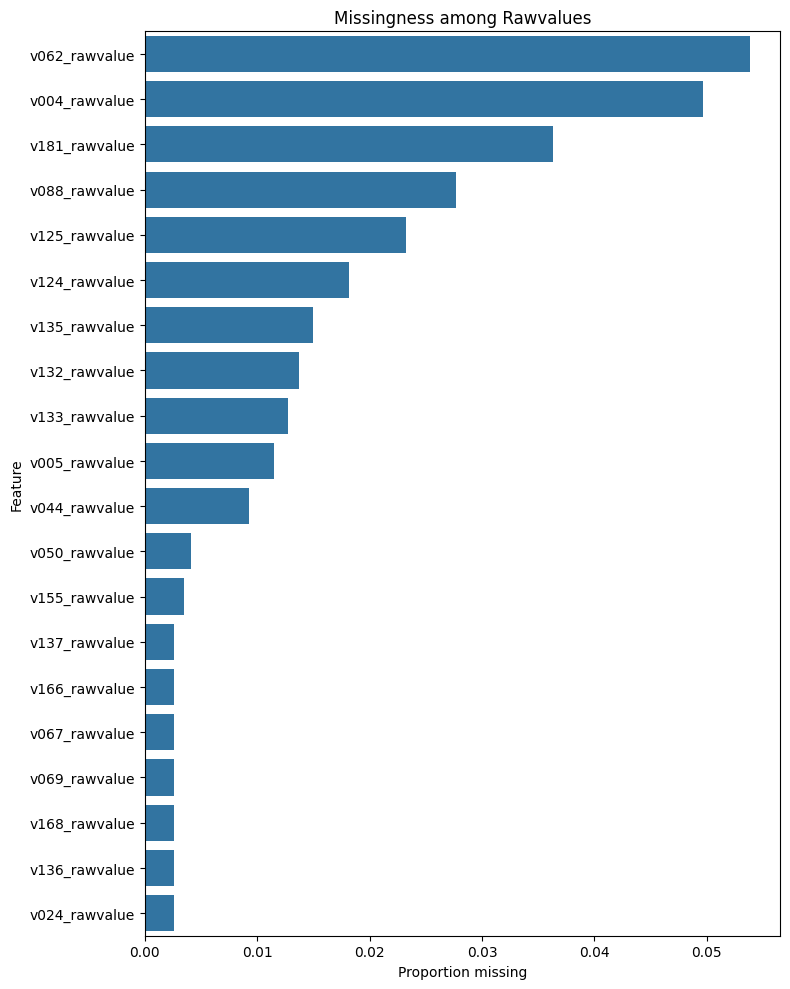

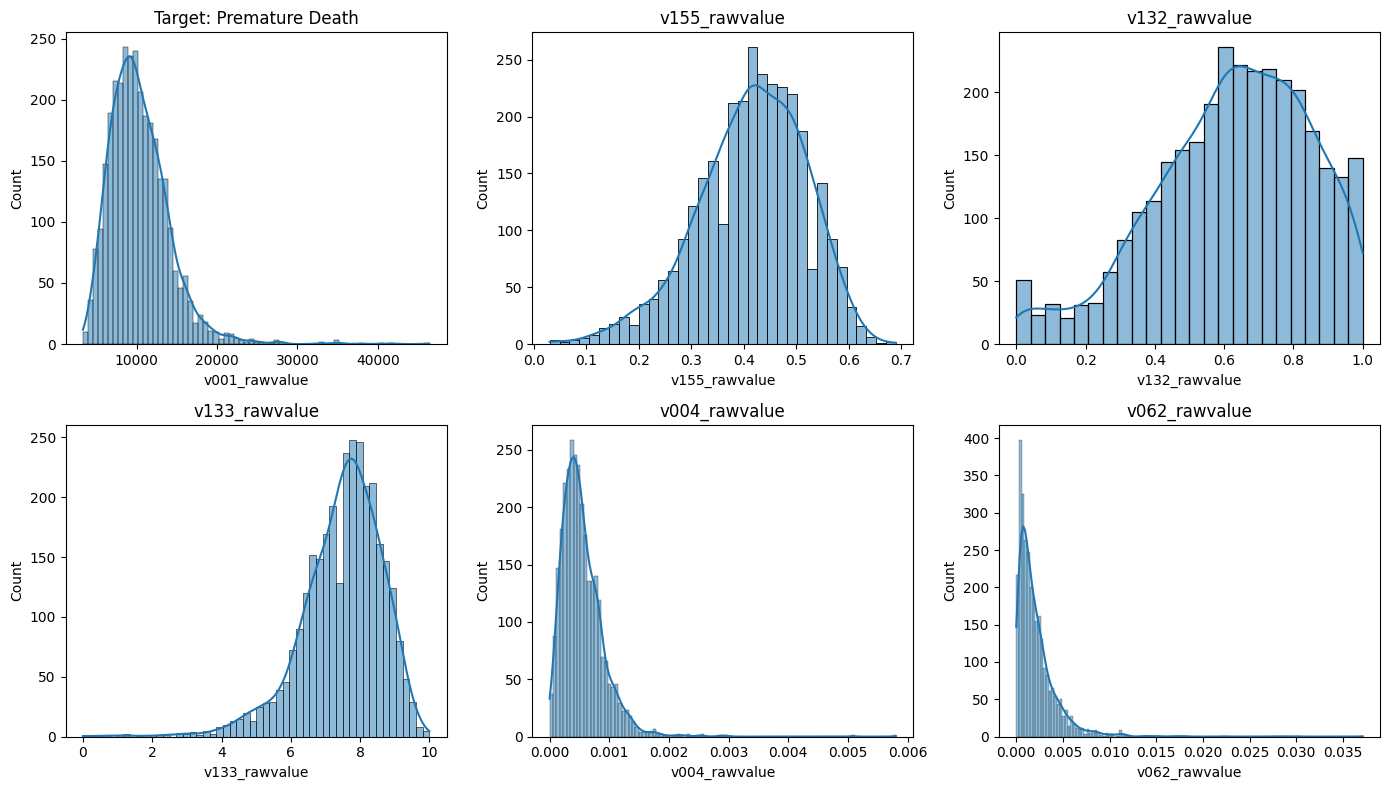

In [236]:
# EDA: Looking for missing data and outliers. Also some basic distribution plots.

# Look at the highest features missing data
missing_pred = work_df[predictor_cols].isna().mean().sort_values(ascending=False).head(20) # Top 20 features missing data
plt.figure(figsize=(8, 10))
sns.barplot(x=missing_pred.values, y=missing_pred.index)
plt.title('Missingness among Rawvalues')
plt.xlabel('Proportion missing')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Basic distributions of target and a few key predictors
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
sns.histplot(work_df[TARGET_COL].dropna(), kde=True, ax=axes[0,0]); axes[0,0].set_title('Target: Premature Death')

for ax, feat in zip(axes.flat[1:], predictor_cols[:5]):
    sns.histplot(work_df[feat].dropna(), kde=True, ax=ax)
    ax.set_title(feat)

plt.tight_layout()
plt.show()



## 5. Preprocessing

In [237]:
# Preprocessing for modeling

# Ensure target exists
assert TARGET_COL in work_df.columns, f"Target {TARGET_COL} missing from work_df"

# Keep only predictor columns that have at least one non-missing value
used_features = [
    c for c in predictor_cols
    if c in work_df.columns and work_df[c].notna().any()
]
assert len(used_features) > 0, "No usable predictor features found (all missing)."

numeric_features = used_features

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

# Working on the numeric features
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
    ],
    remainder='drop',
)

X = work_df[used_features]
y = work_df[TARGET_COL]

# Drop rows without target
mask_target = y.notna()
X = X.loc[mask_target]
y = y.loc[mask_target]

# Print the shapes
print('X shape:', X.shape, 'y non-null:', y.notna().sum(), 'features used:', len(used_features))


X shape: (3140, 24) y non-null: 3140 features used: 24


## 6. Clustering

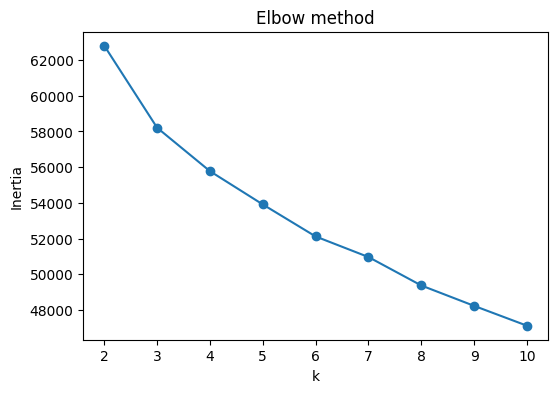

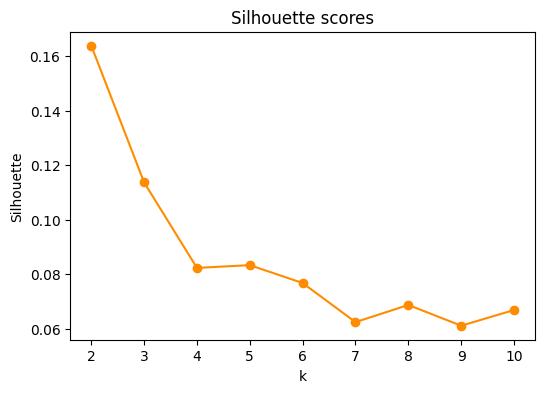

Selected k: 4  which is a manual choice based on the silhouette scores


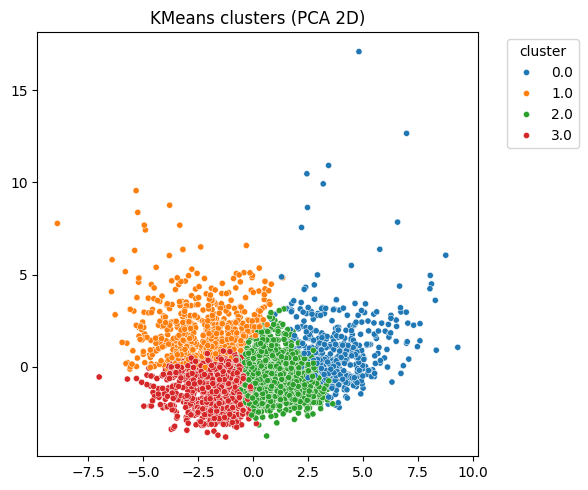

,v155_rawvalue,v132_rawvalue,v133_rawvalue,v004_rawvalue,v062_rawvalue,v088_rawvalue,v005_rawvalue,v050_rawvalue,v085_rawvalue,v136_rawvalue,v001_rawvalue
cluster,,,,,,,,,,,
0.0,0.328599,0.464279,6.016026,0.000364,0.001909,0.000352,3646.289130,0.350043,0.136195,0.151683,15006.435279
1.0,0.488706,0.847468,8.068386,0.000920,0.004355,0.000839,2420.866444,0.453837,0.083153,0.162710,8159.317141
2.0,0.387485,0.550958,7.177611,0.000411,0.001444,0.000367,2952.883231,0.404175,0.121231,0.122055,11408.885131
3.0,0.444253,0.650997,8.221310,0.000541,0.001541,0.000484,2516.749448,0.485341,0.080530,0.102451,8111.739805


In [238]:
# Clustering: KMeans (with K selection)
# Also includes elbow and silhouette plots

# Prepare data for clustering: use separate variables and avoid mutating work_df
numeric_features_clust = predictor_cols
numeric_transformer_clust = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])
preprocess_clust = ColumnTransformer(
    transformers=[("num", numeric_transformer_clust, numeric_features_clust)],
    remainder='drop',
)

X_clust_df = work_df[predictor_cols]
# Drop rows with all-NaN predictors to avoid degenerate rows
X_clust_df = X_clust_df.dropna(how="all")

X_clust = preprocess_clust.fit_transform(X_clust_df)

# Elbow method
inertias = []
K_range = range(2, 11)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init='auto')
    km.fit(X_clust)
    inertias.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(list(K_range), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('k'); plt.ylabel('Inertia')
plt.show()

# Silhouette scores
sil_scores = []
for k in K_range:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init='auto')
    labels = km.fit_predict(X_clust)
    sil = silhouette_score(X_clust, labels)
    sil_scores.append(sil)

# Silhouette plot
plt.figure(figsize=(6,4))
plt.plot(list(K_range), sil_scores, marker='o', color='darkorange')
plt.title('Silhouette scores')
plt.xlabel('k'); plt.ylabel('Silhouette')
plt.show()

# Fit final model with best silhouette
# best_k = int(pd.Series(sil_scores, index=K_range).idxmax())
best_k = 4 # 4 is the best k, in my opinion, based on the silhouette scores
print('Selected k:', best_k, ' which is a manual choice based on the silhouette scores')
final_km = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init='auto')
cluster_labels = final_km.fit_predict(X_clust)

# Attach cluster labels back to work_df 
if 'cluster' not in work_df.columns:
    work_df['cluster'] = np.nan
work_df.loc[X_clust_df.index, 'cluster'] = cluster_labels

# Visualize clusters in 2D
pca = PCA(n_components=2, random_state=RANDOM_STATE)
coords = pca.fit_transform(X_clust)
plt.figure(figsize=(6,5))
sns.scatterplot(x=coords[:,0], y=coords[:,1], hue=work_df.loc[X_clust_df.index, 'cluster'], palette='tab10', s=20)
plt.title('KMeans clusters (PCA 2D)')
plt.legend(title='cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Quick profile of clusters
cols_for_profile = predictor_cols[:10] + ([TARGET_COL] if TARGET_COL in work_df.columns else [])
cluster_means = work_df.loc[X_clust_df.index].groupby('cluster')[cols_for_profile].mean(numeric_only=True)
display(cluster_means)


## 7. Supervised Learning: Predicting Death

In [239]:
# Supervised learning

# Importing the models for sure
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor

# Model 1: LassoCV
lasso = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LassoCV(cv=5, random_state=RANDOM_STATE, n_alphas=100, max_iter=10000))
])

# Model 2: Random Forest
rf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestRegressor(n_estimators=400, random_state=RANDOM_STATE, n_jobs=-1))
])

# Train/test split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

# Fit and evaluate
models = {"LassoCV": lasso, "RandomForest": rf}
results = {}
for name, pipe in models.items():
    pipe.fit(X_tr, y_tr)
    preds = pipe.predict(X_te)
    mse = mean_squared_error(y_te, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_te, preds)
    results[name] = {"RMSE": rmse, "R2": r2}

results_df = pd.DataFrame(results).T.sort_values(by="RMSE")
display(results_df)

# Keep the final feature names used by the transformer for importances
final_feature_names = used_features


,RMSE,R2
RandomForest,2133.497792,0.732336
LassoCV,2244.961447,0.703637


In [240]:
# Feature importance: top 5 factors (with readable measure names)

# Refit on full data
lasso.fit(X, y)
rf.fit(X, y)

# Map 2025 CHR Select Measures, for fun
MEASURE_NAME_MAP = {
    'v004_rawvalue': 'Primary Care Physicians (rate per 100k)',
    'v005_rawvalue': 'Preventable Hospital Stays (per 1,000 Medicare enrollees)',
    'v023_rawvalue': 'Unemployment (%)',
    'v024_rawvalue': 'Children in Poverty (%)',
    'v044_rawvalue': 'Income Inequality (80th/20th ratio)',
    'v050_rawvalue': 'Mammography Screening (%)',
    'v062_rawvalue': 'Mental Health Providers (rate per 100k)',
    'v067_rawvalue': 'Driving Alone to Work (%)',
    'v069_rawvalue': 'Some College (%)',
    'v085_rawvalue': 'Uninsured (%)',
    'v088_rawvalue': 'Dentists (rate per 100k)',
    'v124_rawvalue': 'Drinking Water Violations (0/1 any violation)',
    'v125_rawvalue': 'Air Pollution PM2.5 (µg/m³)',
    'v132_rawvalue': 'Access to Exercise Opportunities (%)',
    'v133_rawvalue': 'Food Environment Index (0–10)',
    'v135_rawvalue': 'Injury Deaths (per 100k)',
    'v136_rawvalue': 'Severe Housing Problems (%)',
    'v137_rawvalue': 'Long Commute - Driving Alone (%)',
    'v140_rawvalue': 'Social Associations (per 10k)',
    'v155_rawvalue': 'Flu Vaccinations (%)',
    'v166_rawvalue': 'Broadband Access (%)',
    'v168_rawvalue': 'High School Completion (%)',
    'v171_rawvalue': 'Child Care Cost Burden (%)',
    'v181_rawvalue': 'Library Access (%)',
}

# Lasso coefficients, sorted by absolute magnitude
lasso_coef = getattr(lasso.named_steps['model'], 'coef_', None)
if lasso_coef is not None:
    coef = pd.Series(lasso_coef, index=final_feature_names)
    top5_lasso = coef.abs().sort_values(ascending=False).head(5)
    top5_lasso_signed = coef[top5_lasso.index]
    top5_lasso_named = top5_lasso_signed.copy()
    top5_lasso_named.index = [MEASURE_NAME_MAP.get(c, c) for c in top5_lasso_named.index]
    display(pd.DataFrame({'LassoCoef': top5_lasso_named}).rename_axis('Measure'))

# RandomForest importances
rf_importances = pd.Series(rf.named_steps['model'].feature_importances_, index=final_feature_names)

top5_rf = rf_importances.sort_values(ascending=False).head(5)

# Display with actual names
top5_rf_named = top5_rf.copy()
top5_rf_named.index = [MEASURE_NAME_MAP.get(c, c) for c in top5_rf_named.index]
display(pd.DataFrame({'RF_Importance': top5_rf_named}).rename_axis('Measure'))

# Keep for reporting
top_feats = top5_rf.index.tolist()
top_feats_named = [MEASURE_NAME_MAP.get(c, c) for c in top_feats]


,LassoCoef
Measure,
Injury Deaths (per 100k),1880.517191
Children in Poverty (%),1339.305993
Driving Alone to Work (%),463.213479
Severe Housing Problems (%),287.784250
"Preventable Hospital Stays (per 1,000 Medicare enrollees)",240.079901


,RF_Importance
Measure,
Children in Poverty (%),0.484827
Injury Deaths (per 100k),0.253472
Income Inequality (80th/20th ratio),0.037442
Driving Alone to Work (%),0.022117
High School Completion (%),0.019055


In [241]:
# Compare model accuracy and choose best based on RMSE

results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('RMSE')
display(results_df)

better = results_df['RMSE'].idxmin()
print('Best model by RMSE:', better)


,RMSE,R2
RandomForest,2133.497792,0.732336
LassoCV,2244.961447,0.703637


Best model by RMSE: RandomForest


## 8. Recommendations for Allegheny County

In [242]:
# Identify Allegheny County rows (FIPS code 42003)
if 'fipscode' in work_df.columns:
    print('fipscode in work_df')
    allegheny_mask = work_df['fipscode'] == 42003
else:
    print('fipscode not in work_df')
    allegheny_mask = False
allegheny = work_df[allegheny_mask]

if not allegheny.empty:
    # Show top RF features using top_feats
    cols = [c for c in existing_id_cols + ([TARGET_COL] if TARGET_COL in work_df.columns else []) + top_feats if c in work_df.columns]
    snap = allegheny[cols].copy()
    display(snap)

    # Compare to national median and percentile
    medians = work_df[top_feats].median(numeric_only=True)
    percentiles = work_df[top_feats].rank(pct=True)
    pct_row = percentiles.loc[allegheny.index[0], top_feats]

    # Compare to national median and percentile
    comp_df = pd.DataFrame({
        'Allegheny': snap.iloc[0][top_feats].values,
        'US Median': medians.values,
        'Percentile': pct_row.values
    }, index=[MEASURE_NAME_MAP.get(c, c) for c in top_feats])
    display(comp_df)
else:
    print('Allegheny County not found in dataset subset.')


fipscode in work_df


,statecode,countycode,fipscode,state,county,year,county_clustered,v001_rawvalue,v024_rawvalue,v135_rawvalue,v044_rawvalue,v067_rawvalue,v168_rawvalue
2296,42,3,42003,PA,Allegheny County,2025,1.0,8412.24812,0.152,108.382956,5.077306,0.632755,0.954698


,Allegheny,US Median,Percentile
Children in Poverty (%),0.152,0.178000,0.364144
Injury Deaths (per 100k),108.382956,96.738215,0.673780
Income Inequality (80th/20th ratio),5.077306,4.428358,0.786885
Driving Alone to Work (%),0.632755,0.782308,0.039591
High School Completion (%),0.954698,0.898740,0.954023


### Recommendations

- Recommendations for Allegheny County	
  - Children in Poverty
    - We need to...
  - Injury Deaths (per 100k)	
  - Income Inequality (80th/20th ratio)
  - Driving Alone to Work (%)
  - High School Completion (%)


